In [41]:
import sys

sys.path.append("../1")

import compare_benchmarks

from matplotlib import pyplot

In [42]:
testList = []
with open("../2/tests.txt") as testsListFile:
    testList = testsListFile.readlines()
    testList = [test.rstrip() for test in testList]
print(testList)

['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'command_buffer_perftests', 'dawn_perf_tests', 'gpu_perftests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'sync_performance_tests', 'tracing_perftests', 'views_perftests', 'viz_perftests']


In [43]:
testsMapping = {}
for test in testList:
    testsMapping[test] = []
    for i in range(1,6):
        testsMapping[test].append(test + "." + str(i) + ".json")

In [44]:
loadedTestMapping = {}
for test in testsMapping:
    loadedTestMapping[test] = []
    for testInstance in testsMapping[test]:
        loadedTestMapping[test].append(compare_benchmarks.load_benchmarks("./test-output/" + testInstance))

In [45]:
loadTestComparisons = {}
for test in loadedTestMapping:
    loadTestComparisons[test] = []
    for testInstance in loadedTestMapping[test][1:]:
        loadTestComparisons[test].append(compare_benchmarks.per_test_comparison(loadedTestMapping[test][0], testInstance))

In [46]:
testComparisonsAverages = {}
for test in loadTestComparisons:
    testComparisonsAverages[test] = []
    for testInstance in loadTestComparisons[test]:
        testComparisonsAverages[test].append(compare_benchmarks.get_average_speedup(testInstance))

In [47]:
print(testComparisonsAverages.keys())

dict_keys(['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'command_buffer_perftests', 'dawn_perf_tests', 'gpu_perftests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'sync_performance_tests', 'tracing_perftests', 'views_perftests', 'viz_perftests'])


dict_keys(['mem_uops_retired.all_loads', 'mem_uops_retired.all_stores'])


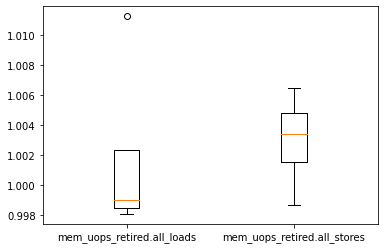

In [52]:
allTestMetrics = {}
for test in testComparisonsAverages:
    allTestMetrics[test] = {}
    for testInstance in testComparisonsAverages[test]:
        for metric in testInstance:
            if metric not in allTestMetrics[test]:
                allTestMetrics[test][metric] = []
            allTestMetrics[test][metric].append(testInstance[metric])
print(metrics.keys())
figure, axis = pyplot.subplots()
axis.boxplot(metrics.values())
axis.set_xticklabels(metrics.keys())
pyplot.show()